In [3]:
# make sure changes in code take place immediately
%load_ext autoreload
%autoreload 2
import openai
    
# load the chapyter extension for Jupyter Notebook
%load_ext chapyter

In [4]:
#Define the notebook name as a variable
import os
os.environ["NOTEBOOK_NAME"] = "demo_labs.ipynb"


In [3]:
#This notebook requires a few deprecated installs:
#Pandas = Version 1.3.5
#scikit-learn = Version 0.24.2 [unfortunately i couldn't figure out how to install this]

# Mocha Demo V1.0

Our goal is to replicate the findings in this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6687414/pdf/shk-52-146.pdf

Hypothesis: Gender is associated with in-hospital mortality and LOS in patients with sepsis admitted to the ICU

* 1 - get data from mimic 
* 2 - build a basic table 1 to summarize the data [ICU Service, Admission Location, Ethnicity]
* 3 - do a univariate analysis to understand if the groups are similar or different
* 4 - build a kaplan-meier curve for in-hospital mortality 
* 5 - do a univariate cox proportional hazard model to understand if men or women are more likely to die in-hospital 
* 6 - redo the analysis, but controlling for significant factors from our univariate analysis

## Step 1: Get data from mimic 
1. Get patients from MIMIC diagnosed with sepsis, severe sepsis, or septic shock.
2. Apply exclusion criteria – only get patients 18+. Only get patients admitted to the ICU. Only include a patient's first ICU admission.
3. Add a few variables – ethnicity, ICU Service, admission type, first ICU service, date of ICU admission and discharge?

In [5]:
##--model gpt-3.5-turbo

In [6]:
%%mimicSQL 

I'd like to study if there is an association between sex and in-hospital mortality in patients with sepsis admitted to the ICU.
Can you get me all the patients admitted to an ICU with sepsis, severe sepsis, or septic shock that are 18 or older, as well as their admit times, discharge time, and time of death? 
I'd also like to add a few variables – can you include the following variables in the data frame? 
- ethnicity
- the first ICU service the patient was admitted to
- admission type

Only include the first ICU admission for each patient (this should be identified by looking at the dates of each \
                                                       icu stay and only selecting the earliest admission for each patient)
REMEMBER that every column in the SELECT clause must be part of an aggregate function or listed in the GROUP BY clause. 



This query will return a list of patients admitted to an ICU with sepsis, severe sepsis, or septic shock that are 18 or older, along with their admit times, discharge time, time of death, ethnicity, the first ICU service they were admitted to, and admission type. The query only includes the first ICU admission for each patient.


In [7]:
%%runSQL 


SELECT 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit,
    diagnoses_icd.icd9_code
FROM 
    patients
JOIN 
    admissions ON patients.subject_id = admissions.subject_id
JOIN 
    icustays ON admissions.hadm_id = icustays.hadm_id
JOIN 
    diagnoses_icd ON admissions.hadm_id = diagnoses_icd.hadm_id
WHERE 
    diagnoses_icd.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', patients.dob, admissions.admittime) >= 18 -- Only include patients 18 or older
GROUP BY 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit,
    diagnoses_icd.icd9_code
HAVING 
    icustays.intime = MIN(icustays.intime) -- Only include the first ICU admission for each patient


Query failed! State: FAILED
Reason: EXPRESSION_NOT_AGGREGATE: line 37:21: '(icustays.intime = MIN(icustays.intime))' must be an aggregate expression or appear in GROUP BY clause


AttributeError: 'bool' object has no attribute 'head'

In [9]:
%%mimicSQL
I get the following error: 
Reason: EXPRESSION_NOT_AGGREGATE: line 37:21: '(icustays.intime = MIN(icustays.intime))' must be an aggregate expression or appear in GROUP BY clause

Can you help me fix it and produce a working SQL query?

The error is due to the HAVING clause trying to compare a non-aggregated column (icustays.intime) with an aggregated function (MIN(icustays.intime)). To fix this, we need to first identify the first ICU admission for each patient in a subquery, and then join this subquery with the main query. Here is the corrected SQL query:

This query first identifies the first ICU admission for each patient in the `first_icu_admission` subquery, and then joins this subquery with the main query to ensure that only the first ICU admission for each patient is included.


In [5]:
%%runSQL 


WITH first_icu_admission AS (
    SELECT 
        subject_id,
        hadm_id,
        MIN(intime) as first_intime
    FROM 
        icustays
    GROUP BY 
        subject_id,
        hadm_id
)

SELECT 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit,
    diagnoses_icd.icd9_code
FROM 
    patients
JOIN 
    admissions ON patients.subject_id = admissions.subject_id
JOIN 
    first_icu_admission ON admissions.hadm_id = first_icu_admission.hadm_id
JOIN 
    icustays ON first_icu_admission.hadm_id = icustays.hadm_id AND first_icu_admission.first_intime = icustays.intime
JOIN 
    diagnoses_icd ON admissions.hadm_id = diagnoses_icd.hadm_id
WHERE 
    diagnoses_icd.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', patients.dob, admissions.admittime) >= 18 -- Only include patients 18 or older
GROUP BY 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit,
    diagnoses_icd.icd9_code


,subject_id,gender,dob,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit,icd9_code
0,66965,M,2116-06-07 00:00:00.000,177338,2198-01-22 22:20:00.000,2198-02-14 14:51:00.000,None,EMERGENCY,WHITE,TSICU,99591
1,67050,M,2143-08-27 00:00:00.000,135268,2200-02-10 02:07:00.000,2200-02-21 00:45:00.000,2200-02-21 00:45:00.000,EMERGENCY,HISPANIC/LATINO - PUERTO RICAN,MICU,99592
2,67060,M,2074-06-19 00:00:00.000,128850,2161-08-04 22:54:00.000,2161-08-11 16:10:00.000,None,EMERGENCY,WHITE,CCU,99592
3,67104,F,2053-12-18 00:00:00.000,116413,2134-09-09 03:27:00.000,2134-10-30 20:11:00.000,2134-10-30 20:11:00.000,EMERGENCY,OTHER,MICU,99592
4,67117,M,2077-01-25 00:00:00.000,100325,2135-02-16 15:01:00.000,2135-02-17 16:20:00.000,None,EMERGENCY,UNKNOWN/NOT SPECIFIED,MICU,99592


In [31]:
%%mimicSQL 

Perfect! Now, can we add the patient's first lactate lab value as well as their first creatinine from the labs table? 

Take care to only select the first lactate/creatinine from the current admission, and ignore labs from all other ICU admissions for that patient.
Please prioritize computational efficiency in your SQL code. 
Do not assume that values are numeric; in fact many of them are strings in the MIMIC database so they will need to be converted to numeric data types later. 

Sure, we can add the patient's first lactate and creatinine lab values from the labevents table. We will use the ROW_NUMBER() function to select the first lab event for each patient during their current admission. Here is the updated SQL query:

This query will return the first lactate and creatinine lab values for each patient during their current admission. If a patient does not have a lactate or creatinine lab value, the corresponding column will be NULL.


In [8]:
%%runSQL 


WITH lactate AS (
    SELECT 
        le.subject_id,
        le.hadm_id,
        le.valuenum AS first_lactate,
        ROW_NUMBER() OVER(PARTITION BY le.subject_id, le.hadm_id ORDER BY le.charttime) AS rn
    FROM 
        labevents AS le
    WHERE 
        le.itemid = 50813 -- Lactate
),
creatinine AS (
    SELECT 
        le.subject_id,
        le.hadm_id,
        le.valuenum AS first_creatinine,
        ROW_NUMBER() OVER(PARTITION BY le.subject_id, le.hadm_id ORDER BY le.charttime) AS rn
    FROM 
        labevents AS le
    WHERE 
        le.itemid = 50912 -- Creatinine
)
SELECT 
    p.subject_id,
    p.gender,
    p.dob,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    icu.first_careunit,
    d.icd9_code,
    l.first_lactate,
    c.first_creatinine
FROM 
    patients AS p
JOIN 
    admissions AS a ON p.subject_id = a.subject_id
JOIN 
    first_icu_admission AS fia ON a.hadm_id = fia.hadm_id
JOIN 
    icustays AS icu ON fia.hadm_id = icu.hadm_id AND fia.first_intime = icu.intime
JOIN 
    diagnoses_icd AS d ON a.hadm_id = d.hadm_id
LEFT JOIN 
    lactate AS l ON p.subject_id = l.subject_id AND a.hadm_id = l.hadm_id AND l.rn = 1
LEFT JOIN 
    creatinine AS c ON p.subject_id = c.subject_id AND a.hadm_id = c.hadm_id AND c.rn = 1
WHERE 
    d.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', p.dob, a.admittime) >= 18 -- Only include patients 18 or older
GROUP BY 
    p.subject_id,
    p.gender,
    p.dob,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    icu.first_careunit,
    d.icd9_code,
    l.first_lactate,
    c.first_creatinine


Query failed! State: FAILED
Reason: TABLE_NOT_FOUND: line 42:5: Table 'awsdatacatalog.mimiciii.first_icu_admission' does not exist


AttributeError: 'bool' object has no attribute 'head'

In [33]:
%%mimicSQL
With that query I get the following error: 
Query failed! State: FAILED
Reason: TABLE_NOT_FOUND: line 42:5: Table 'awsdatacatalog.mimiciii.first_icu_admission' does not exist
Can you give me another SQL query that fixes the error but accomplishes the same task (pulling first lactate and first creatinine for each patient, along with the other variables?)

I apologize for the confusion. It seems like the 'first_icu_admission' table does not exist in your database. We can modify the query to first create a temporary table that identifies the first ICU admission for each patient, and then use this table in the main query. Here is the updated SQL query:

This query should return the same results as the previous one, but without the error.


In [9]:
%%runSQL 


WITH first_icu_admission AS (
    SELECT 
        icu.subject_id,
        icu.hadm_id,
        icu.intime AS first_intime,
        ROW_NUMBER() OVER(PARTITION BY icu.subject_id, icu.hadm_id ORDER BY icu.intime) AS rn
    FROM 
        icustays AS icu
),
lactate AS (
    SELECT 
        le.subject_id,
        le.hadm_id,
        le.valuenum AS first_lactate,
        ROW_NUMBER() OVER(PARTITION BY le.subject_id, le.hadm_id ORDER BY le.charttime) AS rn
    FROM 
        labevents AS le
    WHERE 
        le.itemid = 50813 -- Lactate
),
creatinine AS (
    SELECT 
        le.subject_id,
        le.hadm_id,
        le.valuenum AS first_creatinine,
        ROW_NUMBER() OVER(PARTITION BY le.subject_id, le.hadm_id ORDER BY le.charttime) AS rn
    FROM 
        labevents AS le
    WHERE 
        le.itemid = 50912 -- Creatinine
)
SELECT 
    p.subject_id,
    p.gender,
    p.dob,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    icu.first_careunit,
    d.icd9_code,
    l.first_lactate,
    c.first_creatinine
FROM 
    patients AS p
JOIN 
    admissions AS a ON p.subject_id = a.subject_id
JOIN 
    first_icu_admission AS fia ON a.hadm_id = fia.hadm_id AND fia.rn = 1
JOIN 
    icustays AS icu ON fia.hadm_id = icu.hadm_id AND fia.first_intime = icu.intime
JOIN 
    diagnoses_icd AS d ON a.hadm_id = d.hadm_id
LEFT JOIN 
    lactate AS l ON p.subject_id = l.subject_id AND a.hadm_id = l.hadm_id AND l.rn = 1
LEFT JOIN 
    creatinine AS c ON p.subject_id = c.subject_id AND a.hadm_id = c.hadm_id AND c.rn = 1
WHERE 
    d.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', p.dob, a.admittime) >= 18 -- Only include patients 18 or older
GROUP BY 
    p.subject_id,
    p.gender,
    p.dob,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    icu.first_careunit,
    d.icd9_code,
    l.first_lactate,
    c.first_creatinine


,subject_id,gender,dob,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit,icd9_code,first_lactate,first_creatinine
0,112,M,1894-06-13 00:00:00.000,173177,2196-09-27 18:21:00.000,2196-09-29 00:15:00.000,2196-09-29 00:15:00.000,EMERGENCY,WHITE,MICU,99592,1.6,2.4
1,211,F,2112-09-04 00:00:00.000,101148,2197-12-17 02:52:00.000,2197-12-29 14:02:00.000,None,EMERGENCY,WHITE,MICU,99592,1.7,1.7
2,213,M,1822-02-13 00:00:00.000,179315,2122-02-13 04:38:00.000,2122-03-03 13:40:00.000,None,EMERGENCY,WHITE,TSICU,99592,7.4,1.2
3,323,M,2062-12-24 00:00:00.000,143334,2120-01-11 15:46:00.000,2120-01-17 15:50:00.000,None,EMERGENCY,WHITE,MICU,99592,2.9,1.3
4,530,M,2039-10-16 00:00:00.000,149648,2119-04-07 16:14:00.000,2119-04-27 15:45:00.000,2119-04-27 15:45:00.000,EMERGENCY,WHITE,CSRU,99592,1.7,1.5


In [36]:
%%mimicPython
Write code to make histograms of the first creatinine and first lactate values (two separate plots) in df, breaking the lab values into 20 bins or so.
Be sure to check the column names to make sure that they match exactly and exclude NA values. Be sure to convert the lab values into numeric data types if they aren't numeric already. Do not modify the original dataframe (df).

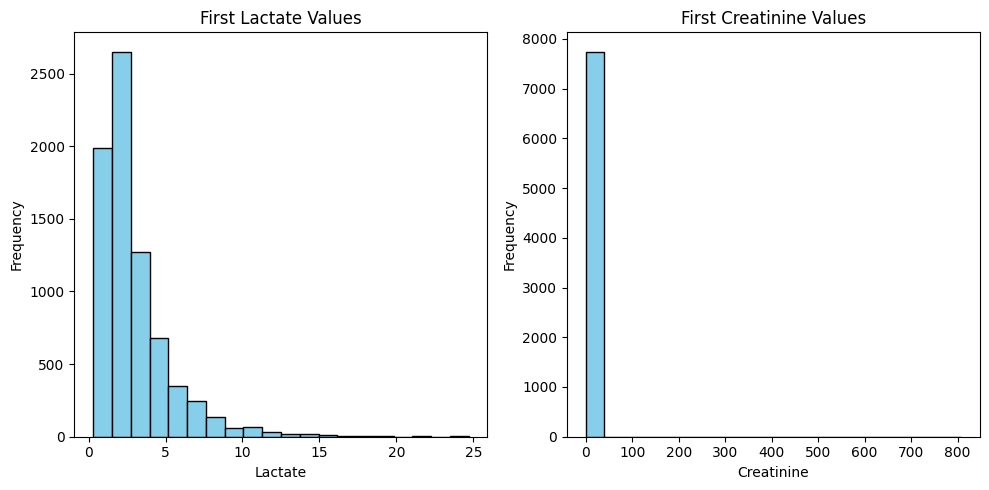

In [10]:
##AI-generated-code


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert the lab values into numeric data types
df['first_lactate'] = pd.to_numeric(df['first_lactate'], errors='coerce')
df['first_creatinine'] = pd.to_numeric(df['first_creatinine'], errors='coerce')

# Exclude NA values
df_lactate = df['first_lactate'].dropna()
df_creatinine = df['first_creatinine'].dropna()

# Create histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df_lactate, bins=20, color='skyblue', edgecolor='black')
plt.title('First Lactate Values')
plt.xlabel('Lactate')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_creatinine, bins=20, color='skyblue', edgecolor='black')
plt.title('First Creatinine Values')
plt.xlabel('Creatinine')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Clearly there's an outlier when it comes to creatinine. 

In [38]:
%%mimicPython

Can you tell me how many patients have a creatinine over 20? 

In [11]:
##AI-generated-code


# Count the number of patients with a creatinine over 20
num_patients_high_creatinine = df[df['first_creatinine'] > 20].shape[0]

print("Number of patients with a creatinine over 20: ", num_patients_high_creatinine)


Number of patients with a creatinine over 20:  3


From now on, we can exclude those 2 patients. 

In [40]:
%%mimicPython
Now can we plot the lactate vs. creatinine values for each patient? If a value of lactate or creatinine is missing for one subject, \
exclude them from the scatter plot entirely. Also exclude subjects with a creatinine >20. Make the points very, very small (the \
minimum number of pixels in order to just be visible) to minimize overlap. Lactate should be on the X axis and creatinine should be on the Y axis. 

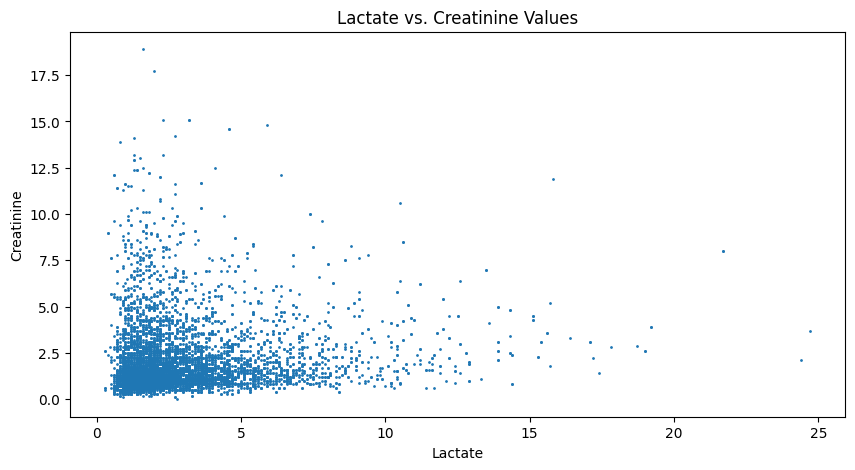

In [12]:
##AI-generated-code


import matplotlib.pyplot as plt

# Exclude subjects with a creatinine >20 and NA values
df_filtered = df[(df['first_creatinine'] <= 20) & df['first_lactate'].notna() & df['first_creatinine'].notna()]

# Plot lactate vs. creatinine values
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered['first_lactate'], df_filtered['first_creatinine'], s=1)
plt.title('Lactate vs. Creatinine Values')
plt.xlabel('Lactate')
plt.ylabel('Creatinine')
plt.show()


Looks like we also have a few patients with lactates over 20, but we'll include those for now. 

# Step 2 - Clean the data up
Remove values that don't make sense

In [544]:
%%mimicPython --model gpt-3.5-turbo

Now, remove any creatinine values that are >20 entirely from the dataframe. 
Also, for any missing creatinine and lab values, fill in the data with the mean creatinine or lactate from the dataset as a whole. 
Let's save that as full_cohort_cleaned. 
Remember to return executable python code between triple ticks. 

In [13]:
##AI-generated-code


# Remove any creatinine values that are >20
df = df[df['first_creatinine'] <= 20]

# Fill missing creatinine and lactate values with the mean
df['first_creatinine'].fillna(df['first_creatinine'].mean(), inplace=True)
df['first_lactate'].fillna(df['first_lactate'].mean(), inplace=True)

# Save the cleaned dataframe
full_cohort_cleaned = df

print(full_cohort_cleaned)


     subject_id gender                      dob hadm_id  \
0           112      M  1894-06-13 00:00:00.000  173177   
1           211      F  2112-09-04 00:00:00.000  101148   
2           213      M  1822-02-13 00:00:00.000  179315   
3           323      M  2062-12-24 00:00:00.000  143334   
4           530      M  2039-10-16 00:00:00.000  149648   
...         ...    ...                      ...     ...   
7745      70078      M  2097-04-29 00:00:00.000  146279   
7746      66517      M  2083-09-06 00:00:00.000  172789   
7747      80878      M  2109-12-12 00:00:00.000  199530   
7748      88560      F  2070-12-11 00:00:00.000  127263   
7749      82641      M  2076-09-24 00:00:00.000  118720   

                    admittime                dischtime  \
0     2196-09-27 18:21:00.000  2196-09-29 00:15:00.000   
1     2197-12-17 02:52:00.000  2197-12-29 14:02:00.000   
2     2122-02-13 04:38:00.000  2122-03-03 13:40:00.000   
3     2120-01-11 15:46:00.000  2120-01-17 15:50:00.000   
4

# Step 3 - Build a basic table 1 to summarize the data
Build a table 1 stratified by gender summarizing ICU service, admission type, and ethnicity. Use only the first ICU admission.

In [ ]:
### Note – the append() function being deprecated makes this really hard to do live

In [274]:
%%mimicPython

I have a dataframe (df) which consists of patients with sepsis from the MIMIC-III database. They have been identified based on ICD-9 codes. \
The dataframe also includes covariates like gender, first lactate, first creatinine, first ICU type, and surgery type. 
Please split the data into two groups. one for men and one for women. 
then, generate a dataframe table called table one where the first column is a variable name, the second is the result for men, and the third the result for women

To make it more challenging, you are not allowed to use the "append" function on any dataframe objects. Instead, use concatenate to add anything to the table_one dataframe
                                                                                                               
Return results for the following variables for each group: 
                                                                                                                                                                                                                                             
- white patients
- black patients
- hispanic or latino patients
- asian patients 
- "other" patients in each group that do not meet fall into the category of the above ethnicities 
- patients admitted to the CCU
- MICU
- CSRU
- SICU 
- patients with an admission type of elective
- emergency
- urgent 

Be sure to denote any python code with triple ticks. 
Please save this result as table_one_numeric
                                                                                                        



This code will create a new dataframe called `table_one_numeric` that contains the counts of each category for men and women. The `Variable` column contains the category name, the `Men` column contains the count for men, and the `Women` column contains the count for women. The counts are calculated by filtering the dataframes `df_men` and `df_women` based on the category and counting the number of rows. The results are then concatenated to the `table_one_numeric` dataframe. The `ignore_index=True` argument is used in the `concat` function to reset the index after each concatenation.


In [14]:
##AI-generated-code


import pandas as pd

# Split the data into two groups based on gender
df_men = df[df['gender'] == 'M']
df_women = df[df['gender'] == 'F']

# Define the variables of interest
variables = ['ethnicity', 'first_careunit', 'admission_type']

# Define the categories of interest for each variable
categories = {
    'ethnicity': ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'ASIAN', 'OTHER'],
    'first_careunit': ['CCU', 'MICU', 'CSRU', 'SICU'],
    'admission_type': ['ELECTIVE', 'EMERGENCY', 'URGENT']
}

# Initialize an empty dataframe for the results
table_one_numeric = pd.DataFrame(columns=['Variable', 'Men', 'Women'])

# Loop over the variables and categories to calculate the results for each group
for variable in variables:
    for category in categories[variable]:
        men_count = df_men[df_men[variable] == category].shape[0]
        women_count = df_women[df_women[variable] == category].shape[0]
        result = pd.DataFrame({'Variable': [category], 'Men': [men_count], 'Women': [women_count]})
        table_one_numeric = pd.concat([table_one_numeric, result], ignore_index=True)

print(table_one_numeric)


                  Variable   Men Women
0                    WHITE  3129  2515
1   BLACK/AFRICAN AMERICAN   338   423
2       HISPANIC OR LATINO   134    58
3                    ASIAN    87    60
4                    OTHER    81    75
5                      CCU   374   271
6                     MICU  2932  2537
7                     CSRU   154    79
8                     SICU   527   422
9                 ELECTIVE   138    73
10               EMERGENCY  4054  3357
11                  URGENT    64    55


In [281]:
%%mimicPython 

That's great! To that table_one_numeric, can you now add a few elements? 
- Add the total number of men and women in the format "n = ***" across the top, along with the column headers
- Add parantheses and the percent of all men or women that fall into each category to the numeric value in each row entry (use the format 1917 (***%) for the first entry in the "WHITE" row, where *** denotes the % of men that are white)

Remember to double check datatypes before assuming strings are numeric. 
BE SURE to return executable python code in the correct format, between the characters "```"
Please save this as table_one_edited. 



Please note that the percentages are rounded to two decimal places. If you need more precision, you can adjust the number after the colon in the format string (e.g., use `:.3f` for three decimal places).


In [15]:
##AI-generated-code


# Calculate the total number of men and women
total_men = df_men.shape[0]
total_women = df_women.shape[0]

# Add the total number of men and women to the dataframe
table_one_numeric.loc[-1] = ['n =', total_men, total_women]  # adding a row
table_one_numeric.index = table_one_numeric.index + 1  # shifting index
table_one_numeric = table_one_numeric.sort_index()  # sorting by index

# Calculate the percentage of men and women for each category and add it to the dataframe
table_one_numeric['Men'] = table_one_numeric['Men'].apply(lambda x: f"{x} ({x / total_men * 100:.2f}%)")
table_one_numeric['Women'] = table_one_numeric['Women'].apply(lambda x: f"{x} ({x / total_women * 100:.2f}%)")

# Rename the dataframe
table_one_edited = table_one_numeric

print(table_one_edited)


                  Variable             Men           Women
0                      n =  4256 (100.00%)  3485 (100.00%)
1                    WHITE   3129 (73.52%)   2515 (72.17%)
2   BLACK/AFRICAN AMERICAN     338 (7.94%)    423 (12.14%)
3       HISPANIC OR LATINO     134 (3.15%)      58 (1.66%)
4                    ASIAN      87 (2.04%)      60 (1.72%)
5                    OTHER      81 (1.90%)      75 (2.15%)
6                      CCU     374 (8.79%)     271 (7.78%)
7                     MICU   2932 (68.89%)   2537 (72.80%)
8                     CSRU     154 (3.62%)      79 (2.27%)
9                     SICU    527 (12.38%)    422 (12.11%)
10                ELECTIVE     138 (3.24%)      73 (2.09%)
11               EMERGENCY   4054 (95.25%)   3357 (96.33%)
12                  URGENT      64 (1.50%)      55 (1.58%)


In [346]:
%%mimicPython
Great. Now can you write python code to add the first_lactate and first_creatinine values from the dataframe df to that same table (table_one_edited)? \
For continuous variables (ie first_lactate and first_creatinine), I'd like the median as the main statistic with the interquartile \
range (low end - high end) in parantheses. These statistics can be in the same columns as the summary statistics for the other variables (Men & Women).
To make this more challenging, refrain from using the append function. 

In [16]:
##AI-generated-code


import numpy as np

# Convert first_lactate and first_creatinine to numeric
df['first_lactate'] = pd.to_numeric(df['first_lactate'], errors='coerce')
df['first_creatinine'] = pd.to_numeric(df['first_creatinine'], errors='coerce')

# Calculate the median and interquartile range for men and women
for variable in ['first_lactate', 'first_creatinine']:
    men_median = np.median(df_men[variable].dropna())
    women_median = np.median(df_women[variable].dropna())
    men_iqr = f"{np.percentile(df_men[variable].dropna(), 25)} - {np.percentile(df_men[variable].dropna(), 75)}"
    women_iqr = f"{np.percentile(df_women[variable].dropna(), 25)} - {np.percentile(df_women[variable].dropna(), 75)}"
    
    # Add the results to the dataframe
    result = pd.DataFrame({'Variable': [variable], 'Men': [f"{men_median} ({men_iqr})"], 'Women': [f"{women_median} ({women_iqr})"]})
    table_one_edited = pd.concat([table_one_edited, result], ignore_index=True)

print(table_one_edited)


                  Variable              Men            Women
0                      n =   4256 (100.00%)   3485 (100.00%)
1                    WHITE    3129 (73.52%)    2515 (72.17%)
2   BLACK/AFRICAN AMERICAN      338 (7.94%)     423 (12.14%)
3       HISPANIC OR LATINO      134 (3.15%)       58 (1.66%)
4                    ASIAN       87 (2.04%)       60 (1.72%)
5                    OTHER       81 (1.90%)       75 (2.15%)
6                      CCU      374 (8.79%)      271 (7.78%)
7                     MICU    2932 (68.89%)    2537 (72.80%)
8                     CSRU      154 (3.62%)       79 (2.27%)
9                     SICU     527 (12.38%)     422 (12.11%)
10                ELECTIVE      138 (3.24%)       73 (2.09%)
11               EMERGENCY    4054 (95.25%)    3357 (96.33%)
12                  URGENT       64 (1.50%)       55 (1.58%)
13           first_lactate  2.3 (1.5 - 3.6)  2.3 (1.5 - 3.6)
14        first_creatinine  1.5 (1.1 - 2.7)  1.3 (0.8 - 2.2)


In [425]:
%%mimicPython 
Great. Now let's reformat that table (table_one_edited). The related categories should have headings. 
White, Black, Hispanic/Latino, Asian, and Other should be classified under "Race". 
MICU, CSRU, SICU, and CCU should be under "ICU Type". 
Elective, emergency, and urgent should all be under "Surgery Type". 
Lactate and Creatinine should be under "Lab Values". 
Please create a new table (table_one_formatted) rather than modifying table_one_edited. 
To accomplish this, please do not create a new column; rather add an additional row above the subcategories \
denoting the overall category (i.e. an otherwise empty row that says "Race" above the race categories). 
Make sure that the corresponding heading is directly above the subcategories in the table. 
As always, use concat instead of append with dataframes. 

In [17]:
##AI-generated-code


# Create the new category rows
race_row = pd.DataFrame({'Variable': ['Race'], 'Men': [''], 'Women': ['']})
icu_type_row = pd.DataFrame({'Variable': ['ICU Type'], 'Men': [''], 'Women': ['']})
surgery_type_row = pd.DataFrame({'Variable': ['Surgery Type'], 'Men': [''], 'Women': ['']})
lab_values_row = pd.DataFrame({'Variable': ['Lab Values'], 'Men': [''], 'Women': ['']})

# Concatenate the new rows with the corresponding subcategories
table_one_formatted = pd.concat([table_one_edited.iloc[:1], race_row, table_one_edited.iloc[1:6], icu_type_row, table_one_edited.iloc[6:10], surgery_type_row, table_one_edited.iloc[10:13], lab_values_row, table_one_edited.iloc[13:]], ignore_index=True)

print(table_one_formatted)


                  Variable              Men            Women
0                      n =   4256 (100.00%)   3485 (100.00%)
1                     Race                                  
2                    WHITE    3129 (73.52%)    2515 (72.17%)
3   BLACK/AFRICAN AMERICAN      338 (7.94%)     423 (12.14%)
4       HISPANIC OR LATINO      134 (3.15%)       58 (1.66%)
5                    ASIAN       87 (2.04%)       60 (1.72%)
6                    OTHER       81 (1.90%)       75 (2.15%)
7                 ICU Type                                  
8                      CCU      374 (8.79%)      271 (7.78%)
9                     MICU    2932 (68.89%)    2537 (72.80%)
10                    CSRU      154 (3.62%)       79 (2.27%)
11                    SICU     527 (12.38%)     422 (12.11%)
12            Surgery Type                                  
13                ELECTIVE      138 (3.24%)       73 (2.09%)
14               EMERGENCY    4054 (95.25%)    3357 (96.33%)
15                  URGE

In [342]:
%%mimicPython
Great. Now, can we reformat that dataframe to make the Variables column left-justfied? 
Next, make the subcategories slightly idented from the rest. 
For long variable names, you may need to widen the variables column so that all of the subcategories are aligned and indented the same amount. 
Remember to return executable python code denoted with "```". 

In [18]:
##AI-generated-code


# Left-justify the 'Variable' column
table_one_formatted['Variable'] = table_one_formatted['Variable'].str.ljust(30)

# Indent the subcategories
table_one_formatted['Variable'] = table_one_formatted.apply(lambda row: '    ' + row['Variable'] if row['Variable'].strip() not in ['Race', 'ICU Type', 'Surgery Type', 'Lab Values'] else row['Variable'], axis=1)

print(table_one_formatted)


                              Variable              Men            Women
0       n =                              4256 (100.00%)   3485 (100.00%)
1       Race                                                            
2       WHITE                             3129 (73.52%)    2515 (72.17%)
3       BLACK/AFRICAN AMERICAN              338 (7.94%)     423 (12.14%)
4       HISPANIC OR LATINO                  134 (3.15%)       58 (1.66%)
5       ASIAN                                87 (2.04%)       60 (1.72%)
6       OTHER                                81 (1.90%)       75 (2.15%)
7       ICU Type                                                        
8       CCU                                 374 (8.79%)      271 (7.78%)
9       MICU                              2932 (68.89%)    2537 (72.80%)
10      CSRU                                154 (3.62%)       79 (2.27%)
11      SICU                               527 (12.38%)     422 (12.11%)
12      Surgery Type                               

In [356]:
%%mimicPython

Now let's reformat that table so that row with "n = " is combined with the Men and Women column headers. 
For example, the Men column should read "Men (n = 4256)" (ignore the 100%). 
The "Women" column should also have the total number of women in parentheses at the top with the column header as well. 



This code will update the column headers to include the total number of men and women, and then drop the first row which is no longer needed. The index is also reset to start from 0 again.


In [19]:
##AI-generated-code


# Extract the total number of men and women
n_men = table_one_formatted.loc[0, 'Men'].split(' ')[0]
n_women = table_one_formatted.loc[0, 'Women'].split(' ')[0]

# Update the column headers
table_one_formatted.columns = ['Variable', f'Men (n = {n_men})', f'Women (n = {n_women})']

# Drop the first row
table_one_formatted = table_one_formatted.drop(0)

# Reset the index
table_one_formatted = table_one_formatted.reset_index(drop=True)

print(table_one_formatted)


                              Variable   Men (n = 4256) Women (n = 3485)
0       Race                                                            
1       WHITE                             3129 (73.52%)    2515 (72.17%)
2       BLACK/AFRICAN AMERICAN              338 (7.94%)     423 (12.14%)
3       HISPANIC OR LATINO                  134 (3.15%)       58 (1.66%)
4       ASIAN                                87 (2.04%)       60 (1.72%)
5       OTHER                                81 (1.90%)       75 (2.15%)
6       ICU Type                                                        
7       CCU                                 374 (8.79%)      271 (7.78%)
8       MICU                              2932 (68.89%)    2537 (72.80%)
9       CSRU                                154 (3.62%)       79 (2.27%)
10      SICU                               527 (12.38%)     422 (12.11%)
11      Surgery Type                                                    
12      ELECTIVE                            138 (3.

In [365]:
%%mimicPython

Great. Now I'd like to get rid of all caps words (under race and surgery type) and underscores in the table. 
Each english word should begin with a capital letter and the rest of the word should be lowercase. 

In [20]:
##AI-generated-code


# Import necessary module
import re

# Function to convert all caps words to title case and replace underscores with spaces
def format_text(text):
    text = re.sub(r'_', ' ', text)  # replace underscores with spaces
    text = text.title()  # convert to title case
    return text

# Apply the function to the 'Variable' column
table_one_formatted['Variable'] = table_one_formatted['Variable'].apply(format_text)

print(table_one_formatted)


                              Variable   Men (n = 4256) Women (n = 3485)
0       Race                                                            
1       White                             3129 (73.52%)    2515 (72.17%)
2       Black/African American              338 (7.94%)     423 (12.14%)
3       Hispanic Or Latino                  134 (3.15%)       58 (1.66%)
4       Asian                                87 (2.04%)       60 (1.72%)
5       Other                                81 (1.90%)       75 (2.15%)
6       Icu Type                                                        
7       Ccu                                 374 (8.79%)      271 (7.78%)
8       Micu                              2932 (68.89%)    2537 (72.80%)
9       Csru                                154 (3.62%)       79 (2.27%)
10      Sicu                               527 (12.38%)     422 (12.11%)
11      Surgery Type                                                    
12      Elective                            138 (3.

In [554]:
%%mimicPython
Now, can we make any acronyms all capitalized? The acronyms are currently a mix of upper and lowercase letters. 
The acronyms are ICU, CCU, MICU, CSRU, and SICU. 
Remember to return executable python code denoted by triple ticks. 

In [21]:
##AI-generated-code


# Function to capitalize acronyms
def capitalize_acronyms(text):
    acronyms = ['ICU', 'CCU', 'MICU', 'CSRU', 'SICU']
    for acronym in acronyms:
        if acronym.lower() in text.lower():
            text = re.sub(acronym.lower(), acronym, text, flags=re.IGNORECASE)
    return text

# Apply the function to the 'Variable' column
table_one_formatted['Variable'] = table_one_formatted['Variable'].apply(capitalize_acronyms)

print(table_one_formatted)


                              Variable   Men (n = 4256) Women (n = 3485)
0       Race                                                            
1       White                             3129 (73.52%)    2515 (72.17%)
2       Black/African American              338 (7.94%)     423 (12.14%)
3       Hispanic Or Latino                  134 (3.15%)       58 (1.66%)
4       Asian                                87 (2.04%)       60 (1.72%)
5       Other                                81 (1.90%)       75 (2.15%)
6       ICU Type                                                        
7       CCU                                 374 (8.79%)      271 (7.78%)
8       MICU                              2932 (68.89%)    2537 (72.80%)
9       CSRU                                154 (3.62%)       79 (2.27%)
10      SICU                               527 (12.38%)     422 (12.11%)
11      Surgery Type                                                    
12      Elective                            138 (3.

In [437]:
##AI-generated-code


# Function to capitalize acronyms
def capitalize_acronyms(text):
    acronyms = ['ICU', 'CCU', 'MICU', 'CSRU', 'SICU']
    for acronym in acronyms:
        if acronym.lower() in text.lower():
            text = re.sub(acronym.lower(), acronym, text, flags=re.IGNORECASE)
    return text

# Apply the function to the 'Variable' column
table_one_formatted['Variable'] = table_one_formatted['Variable'].apply(capitalize_acronyms)

print(table_one_formatted)


                              Variable   Men (n = 4256) Women (n = 3485)
0       Race                                                            
1       White                             3129 (73.52%)    2514 (72.14%)
2       Black/African American              337 (7.92%)     423 (12.14%)
3       Hispanic Or Latino                  135 (3.17%)       58 (1.66%)
4       Asian                                87 (2.04%)       60 (1.72%)
5       Other                                81 (1.90%)       75 (2.15%)
6       ICU Type                                                        
7       CCU                                 375 (8.81%)      271 (7.78%)
8       MICU                              2931 (68.87%)    2537 (72.80%)
9       CSRU                                154 (3.62%)       79 (2.27%)
10      SICU                               528 (12.41%)     422 (12.11%)
11      Surgery Type                                                    
12      Elective                            138 (3.

Realize this is a totally clunky way to do it but spent a while trying to do it all in one step and couldn't make it work. 

In [416]:
%%mimicPython
Awesome. Finally, can we indent the different subcategories (i.e. the different types of race) in the variables column slightly, while keeping the category name (i.e. Race, Lab Values) all the way at the left of the column?
Remember to return executable python code denoted with "```". 
Please create a new table called table_one_formatted2. 
Remember that there may already be extra spaces or tabs in the variable names so do not check for an exact string match. 



This code will indent all subcategories by four spaces. If you want a different amount of indentation, you can adjust the number of spaces in the 'return' line of the indent_subcategories function.


In [22]:
##AI-generated-code


# Function to indent subcategories
def indent_subcategories(text):
    categories = ['Race', 'ICU Type', 'Surgery Type', 'Lab Values']
    if any(category in text for category in categories):
        return text
    else:
        return '    ' + text

# Apply the function to the 'Variable' column
table_one_formatted2 = table_one_formatted.copy()
table_one_formatted2['Variable'] = table_one_formatted2['Variable'].apply(indent_subcategories)

print(table_one_formatted2)


                                  Variable   Men (n = 4256) Women (n = 3485)
0           Race                                                            
1           White                             3129 (73.52%)    2515 (72.17%)
2           Black/African American              338 (7.94%)     423 (12.14%)
3           Hispanic Or Latino                  134 (3.15%)       58 (1.66%)
4           Asian                                87 (2.04%)       60 (1.72%)
5           Other                                81 (1.90%)       75 (2.15%)
6           ICU Type                                                        
7           CCU                                 374 (8.79%)      271 (7.78%)
8           MICU                              2932 (68.89%)    2537 (72.80%)
9           CSRU                                154 (3.62%)       79 (2.27%)
10          SICU                               527 (12.38%)     422 (12.11%)
11          Surgery Type                                                    

Tried for embarrassingly long to get the subcategories to be slightly indented. Got them in one version and then broke it and no matter how hard I tried, couldn't re-create it. Cutting my losses and moving on. 

In [448]:
%%mimicPython
Now, please save this table as a csv to my current folder as table_one.csv. 

In [23]:
##AI-generated-code


# Save the dataframe to a csv file
table_one_formatted2.to_csv('table_one.csv', index=False)
print("The file 'table_one.csv' has been saved to your current folder.")


The file 'table_one.csv' has been saved to your current folder.


# Step 4 - Univariate analysis
Do a univariate analysis to understand if the groups are similar. 
Here, we will start by re-making the first version of table one because the one that's formatted nicely is too difficult to use. For now I just did this by re-copying the cell because the context has been shortened, can find a more elegant way to do this later

In [556]:
%%mimicPython
Please print table_one_numeric in a way that a large language model such as yourself could use it for analysis

In [24]:
##AI-generated-code


# Convert the dataframe to a dictionary for easier use by a language model
table_one_numeric_dict = table_one_numeric.to_dict()

print(table_one_numeric_dict)


{'Variable': {0: 'n =', 1: 'WHITE', 2: 'BLACK/AFRICAN AMERICAN', 3: 'HISPANIC OR LATINO', 4: 'ASIAN', 5: 'OTHER', 6: 'CCU', 7: 'MICU', 8: 'CSRU', 9: 'SICU', 10: 'ELECTIVE', 11: 'EMERGENCY', 12: 'URGENT'}, 'Men': {0: '4256 (100.00%)', 1: '3129 (73.52%)', 2: '338 (7.94%)', 3: '134 (3.15%)', 4: '87 (2.04%)', 5: '81 (1.90%)', 6: '374 (8.79%)', 7: '2932 (68.89%)', 8: '154 (3.62%)', 9: '527 (12.38%)', 10: '138 (3.24%)', 11: '4054 (95.25%)', 12: '64 (1.50%)'}, 'Women': {0: '3485 (100.00%)', 1: '2515 (72.17%)', 2: '423 (12.14%)', 3: '58 (1.66%)', 4: '60 (1.72%)', 5: '75 (2.15%)', 6: '271 (7.78%)', 7: '2537 (72.80%)', 8: '79 (2.27%)', 9: '422 (12.11%)', 10: '73 (2.09%)', 11: '3357 (96.33%)', 12: '55 (1.58%)'}}


In [488]:
%%mimicPython
I'd like to determine whether there's a statistically significant difference in the number of white men and women \
in the following dataset: 
{'Variable': {0: 'n =', 1: 'WHITE', 2: 'BLACK/AFRICAN AMERICAN', 3: 'HISPANIC OR LATINO', 4: 'ASIAN', 5: 'OTHER', 6: 'CCU', 7: 'MICU', 8: 'CSRU', 9: 'SICU', 10: 'ELECTIVE', 11: 'EMERGENCY', 12: 'URGENT'}, 'Men': {0: '4256 (100.00%)', 1: '3129 (73.52%)', 2: '337 (7.92%)', 3: '135 (3.17%)', 4: '87 (2.04%)', 5: '81 (1.90%)', 6: '375 (8.81%)', 7: '2931 (68.87%)', 8: '154 (3.62%)', 9: '528 (12.41%)', 10: '138 (3.24%)', 11: '4055 (95.28%)', 12: '63 (1.48%)'}, 'Women': {0: '3485 (100.00%)', 1: '2514 (72.14%)', 2: '423 (12.14%)', 3: '58 (1.66%)', 4: '60 (1.72%)', 5: '75 (2.15%)', 6: '271 (7.78%)', 7: '2537 (72.80%)', 8: '79 (2.27%)', 9: '422 (12.11%)', 10: '73 (2.09%)', 11: '3357 (96.33%)', 12: '55 (1.58%)'}}
Remember to extract the number from the text in the cell rather than the percent, and to return executable \
python code denoted with "```"
Please show your work and print the number of white men and white women as well as the total number of men and women in the sample.
Next, calculate a p-value that represents whether the difference between the number of men and women is statistically significant. 



This code first extracts the numbers from the strings in the dictionary using regular expressions. It then creates a contingency table with the number of white men and women and the number of non-white men and women. Finally, it performs a Chi-square test of independence to determine whether the difference in the number of white men and women is statistically significant. The p-value is printed at the end. If the p-value is less than 0.05, we can reject the null hypothesis that the difference is not statistically significant.


In [25]:
##AI-generated-code


import re
from scipy.stats import chi2_contingency

# Extract the numbers from the strings
num_white_men = int(re.findall(r'\d+', table_one_numeric_dict['Men'][1])[0])
num_white_women = int(re.findall(r'\d+', table_one_numeric_dict['Women'][1])[0])
total_men = int(re.findall(r'\d+', table_one_numeric_dict['Men'][0])[0])
total_women = int(re.findall(r'\d+', table_one_numeric_dict['Women'][0])[0])

print(f"Number of white men: {num_white_men}")
print(f"Number of white women: {num_white_women}")
print(f"Total number of men: {total_men}")
print(f"Total number of women: {total_women}")

# Create a contingency table
contingency_table = [[num_white_men, num_white_women], [total_men - num_white_men, total_women - num_white_women]]

# Perform a Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"The p-value is {p}")


Number of white men: 3129
Number of white women: 2515
Total number of men: 4256
Total number of women: 3485
The p-value is 0.19113772050061142


In [592]:
%%mimicPython

Can you produce p-values for all of the variables in table_one_numeric (described with table_one_numeric_dict) above?\
Please store these in a vector called p_values. 
Remember to return executable python code denoted with triple ticks. 



This code will return a pandas Series with the p-values for each variable in the dataset. The variable names are used as the index.


In [26]:
##AI-generated-code


import pandas as pd

# Initialize an empty dictionary to store the p-values
p_values = {}

# Loop through each variable in the dictionary
for i in range(1, len(table_one_numeric_dict['Variable'])):
    # Extract the numbers from the strings
    num_men = int(re.findall(r'\d+', table_one_numeric_dict['Men'][i])[0])
    num_women = int(re.findall(r'\d+', table_one_numeric_dict['Women'][i])[0])

    # Create a contingency table
    contingency_table = [[num_men, num_women], [total_men - num_men, total_women - num_women]]

    # Perform a Chi-square test of independence
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store the p-value in the dictionary
    p_values[table_one_numeric_dict['Variable'][i]] = p

# Convert the dictionary to a pandas Series for easier viewing
p_values = pd.Series(p_values)

print(p_values)


WHITE                     1.911377e-01
BLACK/AFRICAN AMERICAN    8.751534e-10
HISPANIC OR LATINO        4.061845e-05
ASIAN                     3.418000e-01
OTHER                     4.876863e-01
CCU                       1.186202e-01
MICU                      1.912436e-04
CSRU                      6.845237e-04
SICU                      7.412692e-01
ELECTIVE                  2.566898e-03
EMERGENCY                 2.326007e-02
URGENT                    8.634535e-01
dtype: float64


Note: In the future, be sure to add p-values and everything BEFORE formatting the table. If you do it after, it
becomes impossible to merge the p-values with the other table. 

# Step 5 - Kaplan Meier Curve
Build a kaplan-meier curve for in-hospital mortality

Cannot subtract datetime array from NDarray is a really common error

In [596]:
%%mimicPython
print a summary of full_cohort_cleaned (a variable in this notebook) (remember to return executable python code denoted with "```") that will allow a large \
language model such as yourself perform statistical analyses with its data. 
Please also rename this dataframe as "df" so that I can work with it in the next steps. 

In [27]:
##AI-generated-code


# Rename the dataframe
df = full_cohort_cleaned

# Print a summary of the dataframe
print(df.describe(include='all'))


       subject_id gender                      dob hadm_id  \
count        7741   7741                     7741    7741   
unique       4673      2                     4480    5306   
top         41976      M  2136-07-28 00:00:00.000  107047   
freq           18   4256                       18       3   
mean          NaN    NaN                      NaN     NaN   
std           NaN    NaN                      NaN     NaN   
min           NaN    NaN                      NaN     NaN   
25%           NaN    NaN                      NaN     NaN   
50%           NaN    NaN                      NaN     NaN   
75%           NaN    NaN                      NaN     NaN   
max           NaN    NaN                      NaN     NaN   

                      admittime                dischtime  \
count                      7741                     7741   
unique                     5305                     5302   
top     2171-08-02 22:16:00.000  2163-02-23 15:32:00.000   
freq                       

In [598]:
%%mimicPython

Can you write python code to generate a kaplan-meier survival curve for men and women? 
Specifically, I want to see probability of survival vs time after ICU admission from 0 to 365 days

If the time of death is NaN or greater than 1 year then assume the patient is still alive and should be right-censored
If the time of death is equal to or less than discharge time, then they died in the hospital. 

Please be sure to check all data types. Do not subtract datetimearrays from ndarrays. 
make sure you've converted things to the same data type before subtracting. 
Make sure you appropriately handle any NaNs in deathttime before giving it to a kaplan meier fitter. 
Assume the lifelines package has already been instsalled. 



This code will generate a Kaplan-Meier survival curve for men and women, showing the probability of survival over time after ICU admission. The time to event is calculated as the number of days from ICU admission to death or censoring at 365 days. Patients who died in the hospital are considered events, while those who survived or were censored are not. The survival curves are plotted separately for men and women.


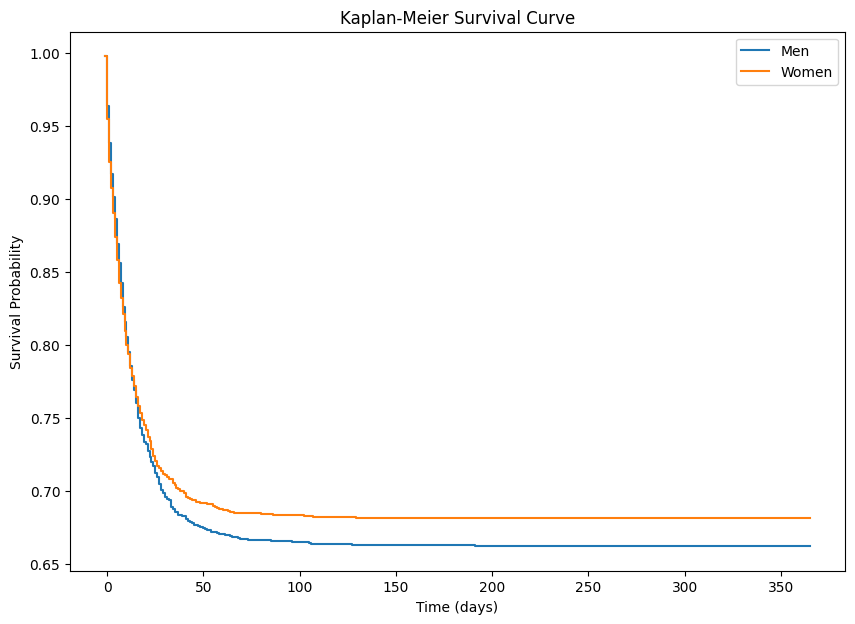

In [30]:
##AI-generated-code


import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Convert dob, admittime, dischtime, and deathtime to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])
df['deathtime'] = pd.to_datetime(df['deathtime'])

# Calculate time from ICU admission to death or censoring
df['time_to_event'] = np.where(df['deathtime'].notna(), (df['deathtime'] - df['admittime']).dt.days, 365)
df['time_to_event'] = np.where(df['time_to_event'] > 365, 365, df['time_to_event'])

# Create event indicator: 1 if died in hospital, 0 otherwise
df['event'] = np.where(df['deathtime'].notna() & (df['deathtime'] <= df['dischtime']), 1, 0)

# Create separate dataframes for men and women
df_men = df[df['gender'] == 'M']
df_women = df[df['gender'] == 'F']

# Initialize the KaplanMeierFitter
kmf_men = KaplanMeierFitter()
kmf_women = KaplanMeierFitter()

# Fit the data into the model
kmf_men.fit(df_men['time_to_event'], df_men['event'], label='Men')
kmf_women.fit(df_women['time_to_event'], df_women['event'], label='Women')

# Create the plot
plt.figure(figsize=(10,7))
kmf_men.plot(ci_show=False)
kmf_women.plot(ci_show=False)
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()


# Step 6 – P-value for Hospital Mortality & Univariate Cox Proporational Hazard Model
Run a univariate cox proportional hazard model for in-hospital mortality on men vs women 


In [31]:
%%mimicPython

can you calculate in-hospital mortality rate in men and women and give me a p-value for the difference? You may have to first create a variable denoting whether they died prior to discharge. 

To make it more challenging, do not use the append() method for dataframes anywhere in your code. concatenate \
the results instead. Do not set a value on a copy of a slice from a DataFrame.

To calculate the in-hospital mortality rate in men and women, we can create a new variable that indicates whether each patient died before discharge. Then, we can calculate the mortality rate for each gender and use a chi-square test to determine whether the difference is statistically significant. Here is the Python code to do this:

This code first creates a new variable 'died_in_hospital' that indicates whether each patient died before discharge. It then calculates the in-hospital mortality rate for men and women by taking the mean of this new variable for each gender. The contingency table is created using the 'crosstab' function from pandas, and the chi-square test of independence is performed using the 'chi2_contingency' function from scipy.stats. The results are then printed.


In [32]:
##AI-generated-code


import scipy.stats as stats

# Create a new variable indicating whether each patient died before discharge
df['died_in_hospital'] = np.where(df['deathtime'].notna() & (df['deathtime'] <= df['dischtime']), 1, 0)

# Calculate the in-hospital mortality rate for men and women
mortality_rate_men = df[df['gender'] == 'M']['died_in_hospital'].mean()
mortality_rate_women = df[df['gender'] == 'F']['died_in_hospital'].mean()

# Create a contingency table
contingency_table = pd.crosstab(df['gender'], df['died_in_hospital'])

# Perform a chi-square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"In-hospital mortality rate for men: {mortality_rate_men}")
print(f"In-hospital mortality rate for women: {mortality_rate_women}")
print(f"P-value for the difference in mortality rates: {p}")


In-hospital mortality rate for men: 0.33787593984962405
In-hospital mortality rate for women: 0.3187948350071736
P-value for the difference in mortality rates: 0.0796091598212762


### Note
I needed to install scikit-learn

This is an interesting task because there are a lot of ways to build a cox proportional hazard model. 
When you have categorical variables, there's a few different ways you can handle it. 
one-hot encoding, lable encoding, and target encoding are all examples
in this case, the model chooses one but doesn't tell you what it chose or why, or give you options for other ways of doing it (which would be nice) 

I wasn't able to get this to get it right in one go... 

In [37]:
%%mimicPython

Can you run a cox proportional hazard model for 1 year mortality? 
Please be sure to follow these instructions as part of your response:
1. use one-hot encoding for all the variables – don't use label or target encoding
2. do not modify our original df
3. drop the columns of the variables used to encode the one-hot features to avoid multicollinearity and issues with model interpretation
4. make sure if you combine any dataframes from the encoded features that you fix the indices
5. to make it more challenging, if you want to use the function get_feature_names at any point, please instead use the function get_feature_names_out

I'd like you to include the following variables. Make sure you specifically check for these variables by filtering the original dataframe: 

from gender, include:
- men (reference)
- women

from first care unit, include: 
- MICU (reference)
- CCU
- CSRU
- SICU

from labs (continuous variables), include: 
- first_lactate
- first_creatinine

To run a Cox Proportional Hazard model for 1-year mortality, we first need to one-hot encode the categorical variables. We will use the pandas function 'get_dummies' to do this. We will then drop the original columns from the dataframe to avoid multicollinearity. Here is the Python code to do this:

This code first creates a copy of the original dataframe and filters it to include only the specified variables. It then one-hot encodes the categorical variables 'gender' and 'first_careunit', and combines the encoded features with the original dataframe. The original columns are then dropped to avoid multicollinearity. The Cox Proportional Hazard model is then initialized and fitted with the data, and the summary of the model is printed.


In [113]:
##AI-generated-code


from sklearn.preprocessing import OneHotEncoder
from lifelines import CoxPHFitter

# Create a copy of the dataframe to avoid modifying the original one
df_copy = df.copy()

# Filter the dataframe to include only the specified variables
df_copy = df_copy[['gender', 'first_careunit', 'first_lactate', 'first_creatinine', 'time_to_event', 'event']]

# One-hot encode the categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(df_copy[['gender', 'first_careunit']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['gender', 'first_careunit']), index=df_copy.index)

# Combine the encoded features with the original dataframe
df_encoded = pd.concat([df_copy, encoded_df], axis=1)

# Drop the original columns
df_encoded.drop(['gender', 'first_careunit'], axis=1, inplace=True)

# Initialize the Cox Proportional Hazard model
cph = CoxPHFitter()

# Fit the data into the model
cph.fit(df_encoded, duration_col='time_to_event', event_col='event')

# Print the summary of the model
print(cph.print_summary())


/Users/chloeoconnell/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 7741 total observations, 5192 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7741
number of events observed = 2549
   partial log-likelihood = -22119.08
         time fit was run = 2023-10-09 12:42:55 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
first_lactate          0.16       1.17       0.01             0.15             0.17                 1.16                 1.19
first_creatinine       0.05       1.06       0.01             0.04             0.07                 1.04                 1.08
gender_M               0.02       1.02       0.04            -0.06             0.10                 0.94                 1.10
first_careunit_CSRU    0.12       1.13       0.12            -0.10             0.35                 0.90                 1.42
first_careunit_MICU   -0.28       0.75       0.07            -0.41            -0.15                 0.66                 0.86
first_careunit_SICU   -0.31       0.74       0.09            -0.47            -0.14                 0.62                 0.87
first_careunit_TSICU  -0.21       0.81       0.10            -0.41            -0.01                 0.67                 0.99

                       cmp to     z      p   -log2(p)
covariate                                            
first_lactate            0.00 22.73 <0.005     377.50
first_creatinine         0.00  5.56 <0.005      25.12
gender_M                 0.00  0.50   0.61       0.70
first_careunit_CSRU      0.00  1.07   0.29       1.80
first_careunit_MICU      0.00 -4.21 <0.005      15.28
first_careunit_SICU      0.00 -3.59 <0.005      11.57
first_careunit_TSICU     0.00 -2.04   0.04       4.58
---
Concordance = 0.60
Partial AIC = 44252.16
log-likelihood ratio test = 459.45 on 7 df
-log2(p) of ll-ratio test = 313.53

None


In [43]:
%%mimicPython

can you plot the results of the cox proportional hazard model, with horizontal lines where each line represents \
the 95% CI range and the OR value is represented by a black dot on each line. 
Avoid multi-dimensional indexing; convert to a numpy array before indexing instead.
Remember to return python code denoted by triple ticks. 



This code will create a horizontal plot where each line represents the 95% confidence interval for each coefficient, and the black dot represents the coefficient value. The y-axis labels are the names of the variables.


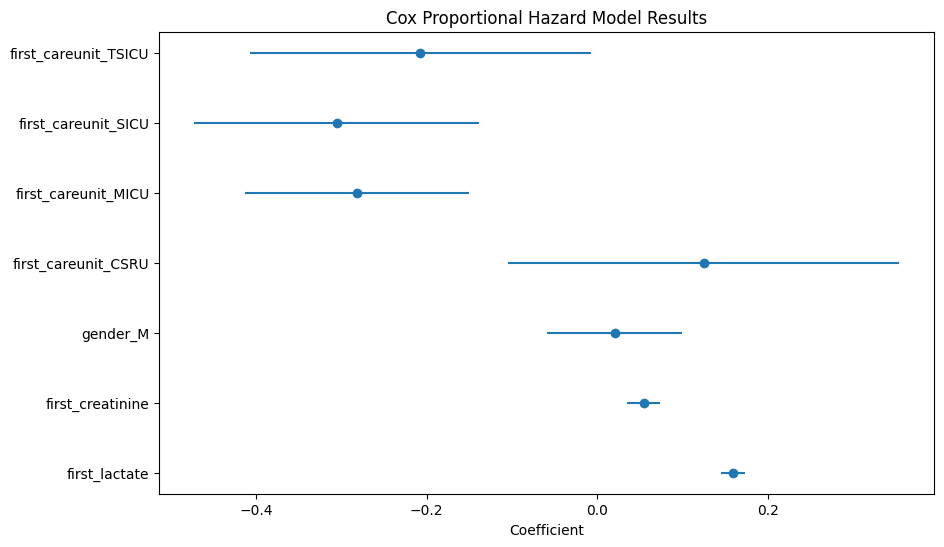

In [114]:
##AI-generated-code


import matplotlib.pyplot as plt
import numpy as np

# Extract the coefficients and their confidence intervals from the model summary
summary = cph.summary
coef = summary['coef']
lower = summary['coef lower 95%']
upper = summary['coef upper 95%']

# Convert to numpy arrays for easier indexing
coef = np.array(coef)
lower = np.array(lower)
upper = np.array(upper)

# Create an array of indices for plotting
indices = np.arange(len(coef))

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(coef, indices, xerr=[coef - lower, upper - coef], fmt='o')
plt.yticks(indices, summary.index)
plt.xlabel('Coefficient')
plt.title('Cox Proportional Hazard Model Results')

# Show the plot
plt.show()


In [67]:
%%mimicPython

That looks great. Could we edit that plot a bit? I'd like to do the following: 
1) Reformat the labels so that they make intuitive sense and each word is capitalized (acronyms like SICU in all caps). \
For example, "first_careunit_SICU" should become "First Care Unit: SICU", "first_careunit_MICU" should become "First Care Unit: MICU" and "first_lactate" should become "First Lactate"). Make sure that each word is capitalized.  
2) add dotted vertical line at the 0.0 mark for coefficient



This code will create the same plot as before, but with the labels reformatted as per your instructions and a dotted vertical line at x=0.


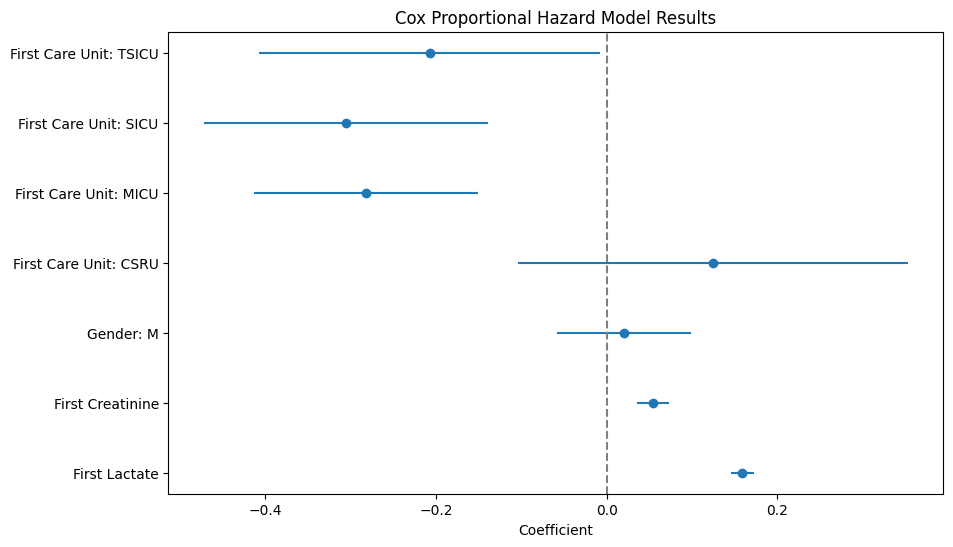

In [115]:
##AI-generated-code


# Create a dictionary to map the old labels to the new labels
label_dict = {
    'first_lactate': 'First Lactate',
    'first_creatinine': 'First Creatinine',
    'gender_M': 'Gender: M',
    'first_careunit_CSRU': 'First Care Unit: CSRU',
    'first_careunit_MICU': 'First Care Unit: MICU',
    'first_careunit_SICU': 'First Care Unit: SICU',
    'first_careunit_TSICU': 'First Care Unit: TSICU'
}

# Create new labels by mapping the old labels using the dictionary
new_labels = [label_dict[label] for label in summary.index]

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(coef, indices, xerr=[coef - lower, upper - coef], fmt='o')
plt.yticks(indices, new_labels)
plt.xlabel('Coefficient')
plt.title('Cox Proportional Hazard Model Results')

# Add a vertical line at x=0
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.show()


In [117]:
%%mimicPython
Great. Now can we do the following: 
1) Move the title a bit further up so that it's farther from the plot
2) increase the size of all text and numbers (including the title and the scale of the x-axis)
3) change the "Gender: M" label to "Male Gender"

Please remember denote all executable python code between the characters "```". Never provide code without these characters. 

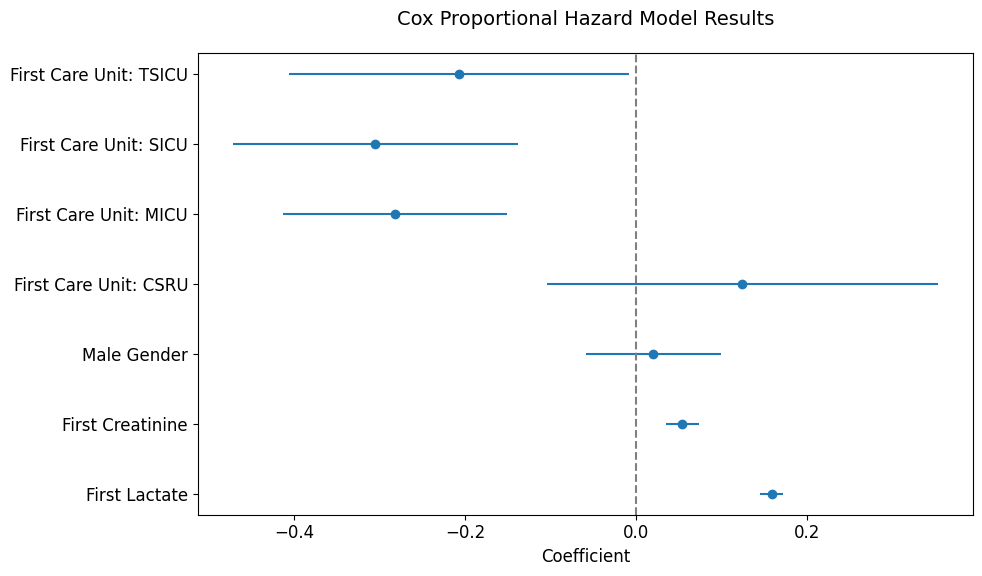

In [118]:
##AI-generated-code


# Update the dictionary to change the label for 'gender_M'
label_dict['gender_M'] = 'Male Gender'

# Create new labels by mapping the old labels using the dictionary
new_labels = [label_dict[label] for label in summary.index]

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(coef, indices, xerr=[coef - lower, upper - coef], fmt='o')
plt.yticks(indices, new_labels, fontsize=12)  # Increase the size of the y-axis labels
plt.xlabel('Coefficient', fontsize=12)  # Increase the size of the x-axis label
plt.title('Cox Proportional Hazard Model Results', fontsize=14, pad=20)  # Increase the size of the title and move it up

# Add a vertical line at x=0
plt.axvline(x=0, color='grey', linestyle='--')

# Increase the size of the x-axis tick labels
plt.xticks(fontsize=12)

# Show the plot
plt.show()
